In [1]:
import HT_control_packagecf as ctrl
import CFmodel
import HT_generate_trajectory as trajgen_thinh
import get_solver_cmpc as cmpc
import numpy as np
import yaml
## Load parameters from config file
with open('Config_Crazyflie_V2.yaml') as f:
    system_parameters = yaml.load(f,Loader=yaml.FullLoader)

qtm_ip = system_parameters['qtm_ip']
Ts = system_parameters['Ts']
Tsim = system_parameters['Tsim']
m = system_parameters['mass']
uris = system_parameters['uris']
drone_bodies = system_parameters['drone_bodies']

## Load Trajectories for drones:
# ref = {}
# vref = {}
# full_ref1 = trajgen_thinh.get_ref_setpoints_Khanh(psi=0,Tsim=Tsim,dt=Ts,agent=1)
# full_ref2 = trajgen_thinh.get_ref_setpoints_Khanh(psi=0,Tsim=Tsim,dt=Ts,agent=2)
# full_ref3 = trajgen_thinh.get_ref_setpoints_Khanh(psi=0,Tsim=Tsim,dt=Ts,agent=3)

# full_ref1 = trajgen_thinh.get_ref_setpoints(psi=0,Tsim=Tsim,dt=Ts,version=11)
# full_ref2 = trajgen_thinh.get_ref_setpoints(psi=0,Tsim=Tsim,dt=Ts,version=12)
# full_ref3 = trajgen_thinh.get_ref_setpoints(psi=0,Tsim=Tsim,dt=Ts,version=13)
# ref = {uris[0]: full_ref1["trajectory"],
#        uris[1]: full_ref2["trajectory"],
#       uris[2]: full_ref3["trajectory"]} 

# vref = {uris[0]: full_ref1["v_ref"],
#         uris[1]: full_ref2["v_ref"],
#         uris[2]: full_ref3["v_ref"]}

# print(np.size(ref[uris[0]],1))
# vref[uris[0]] = np.zeros((np.size(ref[uris[0]],0),3))
# vref[uris[1]] = np.zeros((np.size(ref[uris[1]],0),3))
# vref[uris[2]] = np.zeros((np.size(ref[uris[2]],0),3))


ptf = './Trajectory/traj4UAVs_Vincent3.mat'
full_ref = trajgen_thinh.get_trajectory_mat(path_to_file=ptf,dt=Ts)

ref = {}

vref = {}
for i in range(len(drone_bodies)):
    ref[uris[i]] = full_ref[i]["trajectory"]

    vref[uris[i]] = full_ref[i]["v_ref"]



In [2]:
common_plant,common_controller = cmpc.load_constant_parameters(Ts=Ts)
drone_params = {}
for i in range(len(drone_bodies)):
    drone_params[i] = cmpc.droneParameters(drone_address=uris[i],body_name=drone_bodies[i],mass=m[i],
                                                         plant=common_plant,controller=common_controller) 

central_plant,central_controller,simulator = cmpc.get_stacked_drones_parameters(list_of_drones=drone_params)
simulator['Nsim'] = np.size(ref[uris[0]],0)
# CMPC_solver,CMPC_solver_variables = cmpc.get_solver_cmpc(plant=central_plant,controller=central_controller,simulator=simulator)


simulator['u_sim'] = np.zeros((common_plant['du'],simulator['Nsim'],simulator['na']))
simulator['x_sim'] = np.zeros((common_plant['dx'],simulator['Nsim']+1,simulator['na']))

for i in range(simulator['na']):
    simulator['u_sim'][:,:,i] = np.zeros((common_plant['du'],simulator['Nsim']))
    simulator['x_sim'][:,0,i] = ref[uris[i]][0,:].T 

In [3]:
simulator['un_sim'] = np.zeros((common_plant['du'],simulator['Nsim'],simulator['na']))
simulator['xn_sim'] = np.zeros((common_plant['dx'],simulator['Nsim']+1,simulator['na']))

for i in range(simulator['na']):
    simulator['un_sim'][:,:,i] = np.zeros((common_plant['du'],simulator['Nsim']))
    simulator['xn_sim'][:,0,i] = ref[uris[i]][0,:].T 

In [4]:
import get_solver_CBFQP as cbfqp
solver = {}
dc=0.1
a1=6
a2=8
for i in range(len(drone_bodies)):
    solver[drone_bodies[i]] = cbfqp.CBFQPSolver(v_ref0=vref[uris[i]][0,:],
                                             x_ref0=ref[uris[i]][0,:],
                                             x0=simulator['x_sim'][:,0,i],
                                             a1=a1, a2=a2,dc=dc)
    res = solver[drone_bodies[i]].prob.solve()
    res = solver[drone_bodies[i]].prob.solve()
    res = solver[drone_bodies[i]].prob.solve()
    print(res.x)


[ 1.17668358e-04  3.28507105e-04 -7.52526496e-05]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[ 1.17668358e-04  3.28507105e-04 -7.52526496e-05]
[ 3.27085059e-04 -2.95150330e-05  1.19998493e-04]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[ 3.27085059e-04 -2.95150330e-05  1.19998493e-04]
[0.0001516  0.00017709 0.00021859]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0.0001516  0.00017709 0.00021859]
[-0.00020047  0.00013682  0.00021601]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[-0.00020047  0.00013682  0.00021601]


In [5]:
""" Nominal controller(LQR) and CBF-QP"""

k = 0
Kf = {}
for i in range(len(drone_bodies)):
    Kf[uris[i]]  =  -2.0 *  np.array([[2.5, 0, 0, 1.5, 0, 0],
                                    [0, 2.5, 0, 0, 1.5, 0],
                                    [0, 0, 2.5, 0, 0, 1.5]]) #gain matrix obtained from LQR
import time 
start = time.perf_counter()
while(k< simulator['Nsim']):
    tic = time.perf_counter()
    # if k==0:
    #     u_init = np.zeros((central_plant['du'],1))
    # else:
    #     u_init = simulator['U_total'][:,k-1]
    
    # simulator['X_ref'] = cmpc.get_ref_pred_horz(ref=ref,k=k,Npred=common_controller['Npred']+1,uris=uris)
    # simulator['v_ref'] = cmpc.get_ref_pred_horz(ref=vref,k=k,Npred=common_controller['Npred'],uris=uris)
    # for i in range(simulator['na']):
    #     simulator['X_total'][i*(common_plant['dx']):(i+1)*(common_plant['dx']),k] = simulator['x_sim'][:,k,i]
    
    # simulator['U_total'][:,k] = cmpc.compute_control_cmpc(solver=CMPC_solver,solver_variables=CMPC_solver_variables,X0=simulator['X_total'][:,k],
    #                           v0=u_init,Xrefk=simulator['X_ref'],vrefk = simulator['v_ref'],yawk = 0)
    controls = {}
    for i in range(simulator['na']):
        # simulator['u_sim'][:,k,i] = simulator['U_total'][i*(common_plant['du']):(i+1)*(common_plant['du']),k]
        solver[drone_bodies[0]].update(v_ref=vref[uris[0]][k,:],
                     x_ref=ref[uris[0]][k,:],
                    x=simulator['x_sim'][:,k,0],)
        res = solver[drone_bodies[0]].prob.solve()
        simulator['u_sim'][:,k,i] = res.x + ctrl.compute_control(v_ref=vref[uris[i]][k,:],
                                                                 x0=simulator['x_sim'][:,k,i],
                                                                 xref=ref[uris[i]][k,:],
                                                                 Kf=Kf[uris[i]])
        # compute real control u
        controls[uris[i]] = ctrl.get_real_input(v_controls=simulator['u_sim'][:,k,i],yaw=0)
        
        # disturbance
        disturb = np.zeros((1,3))
        disturb = disturb + np.random.normal(loc=0.0,scale=0.03,size=(1,3))
        simulator['x_sim'][:,k+1,i] = CFmodel.CFmodel(xk=simulator['x_sim'][:,k,i],urk= controls[uris[i]],plant=common_plant,disturb=disturb)

    k = k+1 
    
    # print(f'{time.perf_counter()-tic} sec')
end = time.perf_counter()
calcul_t = end-start


print('Calulation time : ',calcul_t)
print('Average calculation time : ',calcul_t/simulator['Nsim'])

9.80985
9.81004
9.81014
9.81014
9.99177
9.99465
9.98878
10.00626
10.14348
10.1561
10.15517
10.17204
10.35189
10.35657
10.37339
10.36652
10.57513
10.59365
10.60569
10.59626
10.6462
10.64665
10.65951
10.66018
10.57498
10.58784
10.58688
10.58807
10.54125
10.56029
10.54665
10.55591
10.55213
10.56117
10.54816
10.55419
10.51911
10.54564
10.53317
10.52873
10.50325
10.54534
10.50358
10.50477
10.49678
10.53505
10.50982
10.47881
10.5112
10.54557
10.51228
10.50031
10.53659
10.55814
10.51568
10.531
10.48853
10.51304
10.48096
10.50191
10.46959
10.48856
10.46295
10.48131
10.49388
10.51325
10.48289
10.48619
10.39029
10.44239
10.40499
10.42242
10.44247
10.49612
10.45351
10.46404
10.45027
10.505
10.46031
10.46637
10.44794
10.51407
10.44108
10.46241
10.44149
10.50412
10.42675
10.45412
10.45461
10.51142
10.43956
10.48344
10.42927
10.45826
10.42315
10.46208
10.471
10.47856
10.44841
10.4858
10.45639
10.45058
10.43725
10.47458
10.47578
10.47653
10.44777
10.4579
10.46546
10.46206
10.41671
10.4532
10.44503
10

In [6]:
""" Only nominal controller (LQR)"""

k = 0
Kf = {}
for i in range(len(drone_bodies)):
    Kf[uris[i]]  =  -2.0 *  np.array([[2.5, 0, 0, 1.5, 0, 0],
                                    [0, 2.5, 0, 0, 1.5, 0],
                                    [0, 0, 2.5, 0, 0, 1.5]]) #gain matrix obtained from LQR
import time 
start = time.perf_counter()
while(k< simulator['Nsim']):
    tic = time.perf_counter()
    # if k==0:
    #     u_init = np.zeros((central_plant['du'],1))
    # else:
    #     u_init = simulator['U_total'][:,k-1]
    
    # simulator['X_ref'] = cmpc.get_ref_pred_horz(ref=ref,k=k,Npred=common_controller['Npred']+1,uris=uris)
    # simulator['v_ref'] = cmpc.get_ref_pred_horz(ref=vref,k=k,Npred=common_controller['Npred'],uris=uris)
    # for i in range(simulator['na']):
    #     simulator['X_total'][i*(common_plant['dx']):(i+1)*(common_plant['dx']),k] = simulator['x_sim'][:,k,i]
    
    # simulator['U_total'][:,k] = cmpc.compute_control_cmpc(solver=CMPC_solver,solver_variables=CMPC_solver_variables,X0=simulator['X_total'][:,k],
    #                           v0=u_init,Xrefk=simulator['X_ref'],vrefk = simulator['v_ref'],yawk = 0)
    controls = {}
    for i in range(simulator['na']):
        # simulator['u_sim'][:,k,i] = simulator['U_total'][i*(common_plant['du']):(i+1)*(common_plant['du']),k]
        # solver[drone_bodies[0]].update(v_ref=vref[uris[0]][k,:],
        #              x_ref=ref[uris[0]][k,:],
        #             x=simulator['x_sim'][:,k,0],)
        # res = solver[drone_bodies[0]].prob.solve()
        simulator['un_sim'][:,k,i] = ctrl.compute_control(v_ref=vref[uris[i]][k,:],
                                                                 x0=simulator['xn_sim'][:,k,i],
                                                                 xref=ref[uris[i]][k,:],
                                                                 Kf=Kf[uris[i]])
        # compute real control u
        controls[uris[i]] = ctrl.get_real_input(v_controls=simulator['un_sim'][:,k,i],yaw=0)
        
        # disturbance
        disturb = np.zeros((1,3))
        disturb = disturb + np.random.normal(loc=0.0,scale=0.03,size=(1,3))
        simulator['xn_sim'][:,k+1,i] = CFmodel.CFmodel(xk=simulator['xn_sim'][:,k,i],urk= controls[uris[i]],plant=common_plant,disturb=disturb)

    k = k+1 
    
    # print(f'{time.perf_counter()-tic} sec')
end = time.perf_counter()
calcul_t = end-start


print('Calulation time : ',calcul_t)
print('Average calculation time : ',calcul_t/simulator['Nsim'])

9.80992
9.81012
9.81022
9.81022
9.99279
10.01444
10.0026
10.00172
10.16632
10.17837
10.15186
10.16454
10.3048
10.31851
10.29646
10.29339
10.40014
10.42305
10.40682
10.4079
10.47578
10.49727
10.47607
10.47884
10.53383
10.55404
10.52778
10.52754
10.56757
10.58185
10.57454
10.5561
10.57977
10.59599
10.6004
10.58418
10.58954
10.60512
10.61064
10.59746
10.58696
10.60432
10.60003
10.59735
10.59436
10.58948
10.58146
10.57906
10.57725
10.59018
10.5751
10.58088
10.55946
10.59018
10.57189
10.57223
10.54212
10.57105
10.57276
10.54987
10.52884
10.56474
10.55142
10.55303
10.50709
10.5332
10.5217
10.51637
10.51677
10.52057
10.49698
10.50996
10.51492
10.51437
10.47961
10.49782
10.50113
10.48293
10.46838
10.49982
10.46495
10.45805
10.46337
10.49318
10.46192
10.44127
10.45395
10.46754
10.45076
10.42341
10.45341
10.4416
10.43939
10.43808
10.45124
10.43104
10.4233
10.43882
10.44731
10.42776
10.43073
10.42889
10.45792
10.42
10.42643
10.41123
10.46402
10.42451
10.42845
10.41392
10.48394
10.4271
10.40557
10

In [7]:
# plot result

import matplotlib.pyplot as plt
# import matplotlib

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


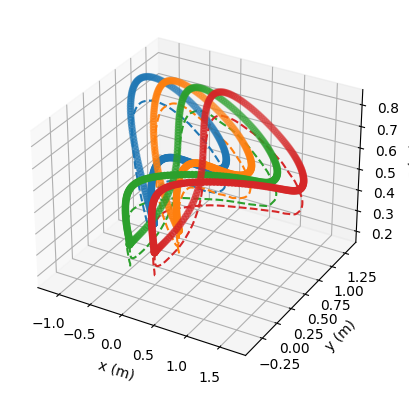

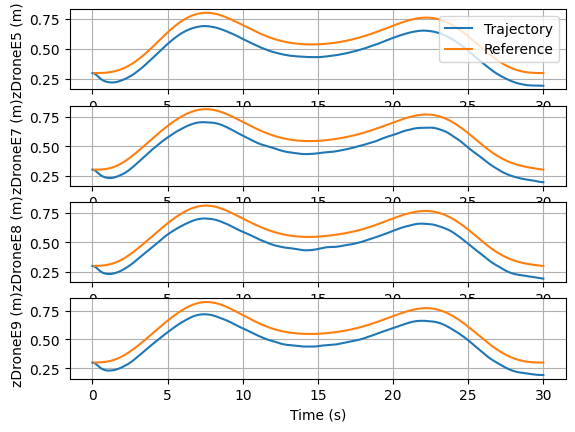

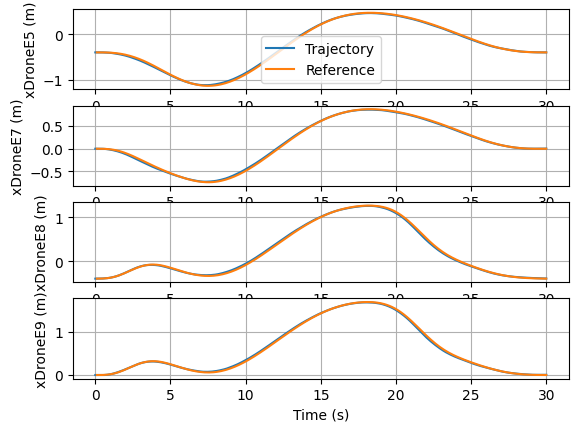

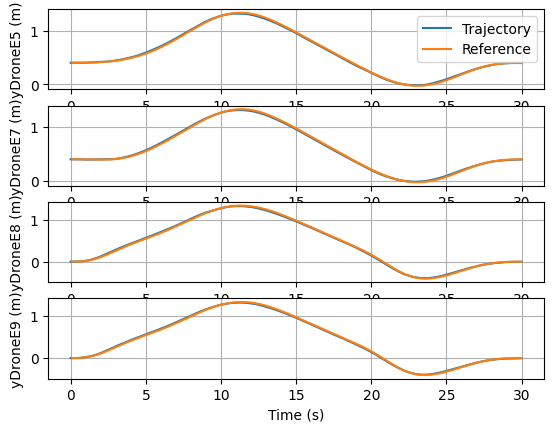

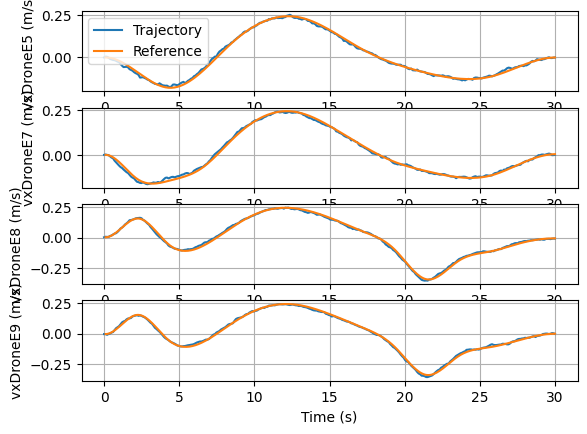

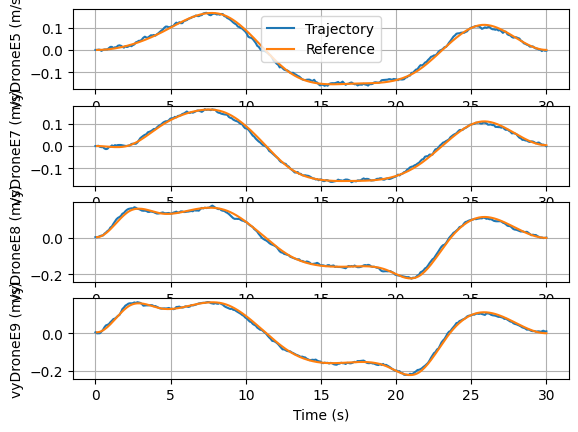

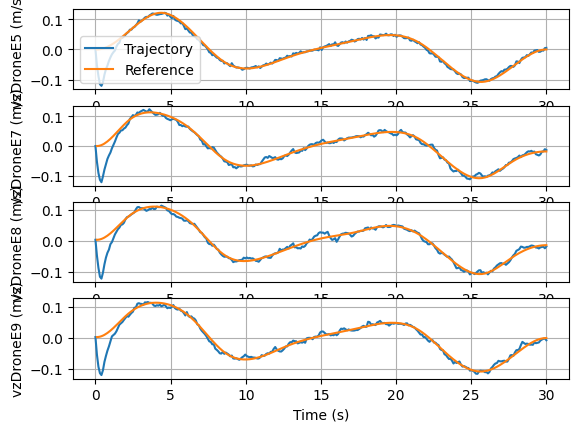

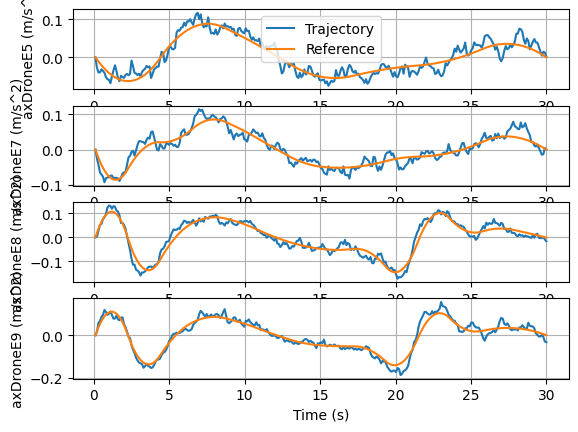

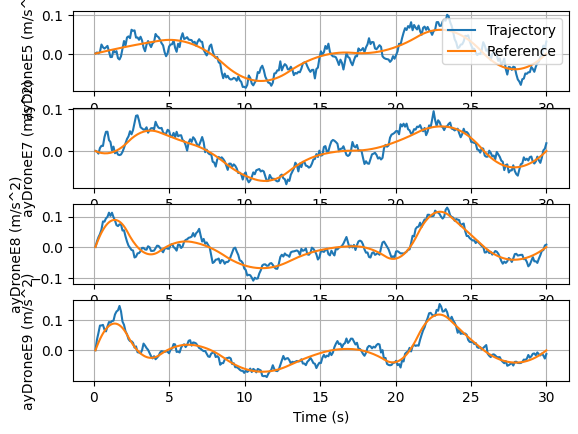

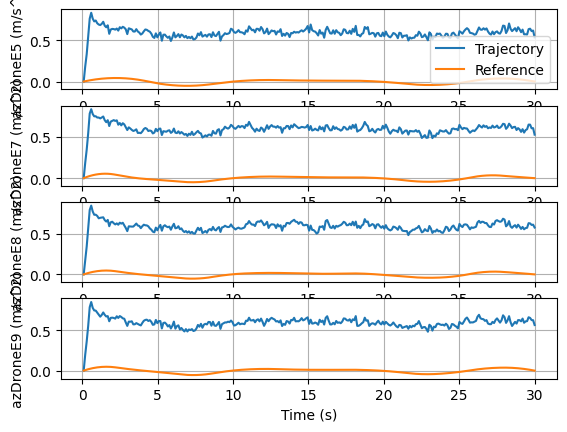

In [8]:
# Enable LaTeX formatting
# plt.rcParams.update({
#     "text.usetex":True,
#     "font.family":"sans-serif"
# })
# Plot position in 3D plot:
fig1 = plt.figure()
ax1 = fig1.add_subplot(projection='3d')


for i in range(len(drone_bodies)):
    ax1.plot(simulator['x_sim'][0,:,i],simulator['x_sim'][1,:,i],simulator['x_sim'][2,:,i], '--')
    ax1.scatter(ref[uris[i]][:,0],ref[uris[i]][:,1],ref[uris[i]][:,2])


ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_zlabel('z (m)')

ts = np.linspace(start=0,stop=Tsim,num=simulator['Nsim']+1)
fig12 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig12.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][2,:,i],label='Trajectory')
    ax1.plot(ts[1:],ref[uris[i]][:,2],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"z{drone_bodies[i]} (m)")
    if (i==0):
        ax1.legend()
fig12.savefig("./Simulation/z_MPC_tracking.eps", format='eps')
fig13 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig13.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][0,:,i],label='Trajectory')
    ax1.plot(ts[1:],ref[uris[i]][:,0],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"x{drone_bodies[i]} (m)")
    if (i==0):
        ax1.legend()
fig13.savefig("./Simulation/x_MPC_tracking.eps", format='eps')
fig14 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig14.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][1,:,i],label='Trajectory')
    ax1.plot(ts[1:],ref[uris[i]][:,1],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"y{drone_bodies[i]} (m)")
    if (i==0):
        ax1.legend()
fig14.savefig("./Simulation/y_MPC_tracking.eps", format='eps')
fig21 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig21.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][3,:,i],label='Trajectory')
    ax1.plot(ts[1:],ref[uris[i]][:,3],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"vx{drone_bodies[i]} (m/s)")
    if (i==0):
        ax1.legend()
fig21.savefig("./Simulation/vx_MPC_tracking.eps", format='eps')
fig22 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig22.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][4,:,i],label='Trajectory')
    ax1.plot(ts[1:],ref[uris[i]][:,4],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"vy{drone_bodies[i]} (m/s)")
    if (i==0):
        ax1.legend()
fig22.savefig("./Simulation/vy_MPC_tracking.eps", format='eps')
fig23 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig23.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts,simulator['x_sim'][5,:,i],label='Trajectory')
    ax1.plot(ts[1:],ref[uris[i]][:,5],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"vz{drone_bodies[i]} (m/s)")
    if (i==0):
        ax1.legend()
fig23.savefig("./Simulation/vz_MPC_tracking.eps", format='eps')
fig31 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig31.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts[1:],simulator['u_sim'][0,:,i],label='Trajectory')
    ax1.plot(ts[1:],vref[uris[i]][:,0],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"ax{drone_bodies[i]} (m/s^2)")
    if (i==0):
        ax1.legend()
fig31.savefig("./Simulation/ax_MPC_tracking.eps", format='eps')
fig32 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig32.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts[1:],simulator['u_sim'][1,:,i],label='Trajectory')
    ax1.plot(ts[1:],vref[uris[i]][:,1],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"ay{drone_bodies[i]} (m/s^2)")
    if (i==0):
        ax1.legend()
fig32.savefig("./Simulation/ay_MPC_tracking.eps", format='eps')
fig33 = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = fig33.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts[1:],simulator['u_sim'][2,:,i],label='Trajectory')
    ax1.plot(ts[1:],vref[uris[i]][:,2],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"az{drone_bodies[i]} (m/s^2)")
    if (i==0):
        ax1.legend()
fig33.savefig("./Simulation/az_MPC_tracking.eps", format='eps')

        


In [9]:
ur = np.zeros((3,simulator['Nsim'],simulator['na']))
for k in range(simulator['Nsim']):
    for i in range(simulator['na']):
        # compute real control u
        ur[:,k,i]= ctrl.get_real_input(v_controls=simulator['u_sim'][:,k,i],yaw=0)

urn = np.zeros((3,simulator['Nsim'],simulator['na']))
for k in range(simulator['Nsim']):
    for i in range(simulator['na']):
        # compute real control u
        urn[:,k,i]= ctrl.get_real_input(v_controls=simulator['un_sim'][:,k,i],yaw=0)

9.80985
9.81004
9.81014
9.81014
9.99177
9.99465
9.98878
10.00626
10.14348
10.1561
10.15517
10.17204
10.35189
10.35657
10.37339
10.36652
10.57513
10.59365
10.60569
10.59626
10.6462
10.64665
10.65951
10.66018
10.57498
10.58784
10.58688
10.58807
10.54125
10.56029
10.54665
10.55591
10.55213
10.56117
10.54816
10.55419
10.51911
10.54564
10.53317
10.52873
10.50325
10.54534
10.50358
10.50477
10.49678
10.53505
10.50982
10.47881
10.5112
10.54557
10.51228
10.50031
10.53659
10.55814
10.51568
10.531
10.48853
10.51304
10.48096
10.50191
10.46959
10.48856
10.46295
10.48131
10.49388
10.51325
10.48289
10.48619
10.39029
10.44239
10.40499
10.42242
10.44247
10.49612
10.45351
10.46404
10.45027
10.505
10.46031
10.46637
10.44794
10.51407
10.44108
10.46241
10.44149
10.50412
10.42675
10.45412
10.45461
10.51142
10.43956
10.48344
10.42927
10.45826
10.42315
10.46208
10.471
10.47856
10.44841
10.4858
10.45639
10.45058
10.43725
10.47458
10.47578
10.47653
10.44777
10.4579
10.46546
10.46206
10.41671
10.4532
10.44503
10

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


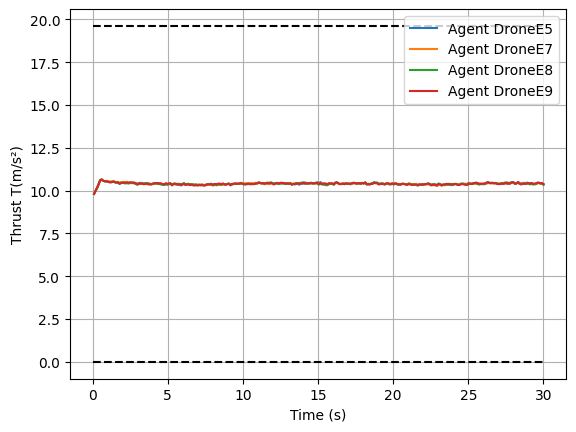

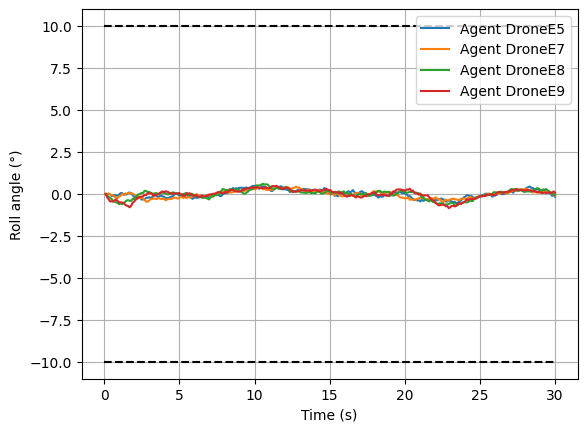

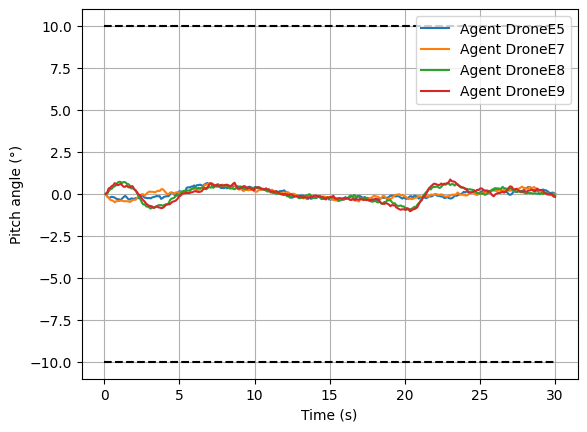

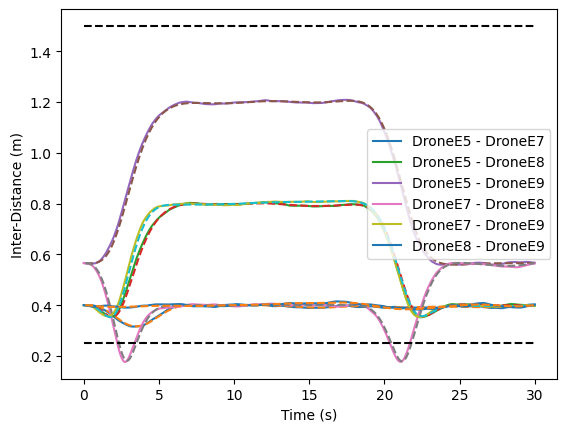

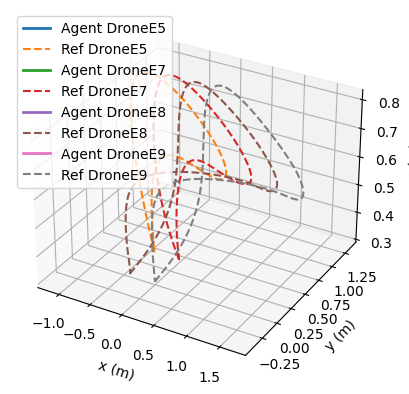

In [10]:
# Create a figure and axis object
fig,ax = plt.subplots()

# plot Thrust
g = 9.81
Tmax = 2 * g
for i in range(simulator['na']):
    ax.plot(ts[1:],ur[0,:,i],label=f'Agent {drone_bodies[i]}')
    ax.grid(visible=True)

ax.plot(ts,np.ones(np.size(ts)) * Tmax,'k--',linewidth=1.5)
ax.plot(ts,np.ones(np.size(ts)) * 0,'k--',linewidth=1.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Thrust T(m/s²)')
ax.legend()
fig.savefig("./Simulation/Thrust_MPC_tracking.eps", format='eps')

phimax = 10 * np.pi/180
thetamax = 10 * np.pi/180

figr,axr = plt.subplots()

for i in range(simulator['na']):
    axr.plot(ts[1:],ur[1,:,i]*180/np.pi,label=f'Agent {drone_bodies[i]}')
    axr.grid(visible=True)

axr.plot(ts,np.ones(np.size(ts)) * phimax*180/np.pi,'k--',linewidth=1.5)
axr.plot(ts,np.ones(np.size(ts)) * -phimax*180/np.pi,'k--',linewidth=1.5)
axr.set_xlabel('Time (s)')
axr.set_ylabel('Roll angle (°)')
axr.legend()
figr.savefig("./Simulation/Roll_MPC_tracking.eps", format='eps')
figp,axp = plt.subplots()

for i in range(simulator['na']):
    axp.plot(ts[1:],ur[2,:,i]*180/np.pi,label=f'Agent {drone_bodies[i]}')
    axp.grid(visible=True)

axp.plot(ts,np.ones(np.size(ts)) * thetamax *180/np.pi,'k--',linewidth=1.5)
axp.plot(ts,np.ones(np.size(ts)) * -thetamax *180/np.pi,'k--',linewidth=1.5)
axp.set_xlabel('Time (s)')
axp.set_ylabel('Pitch angle (°)')
axp.legend()

# Inter-agent distance:
figid,axid = plt.subplots()
dist_max = 1.50
dist_min = 0.25
int_dist = np.zeros((simulator['Nsim']+1,simulator['na'],simulator['na']))
int_dist_ref = np.zeros((simulator['Nsim'],simulator['na'],simulator['na']))
for i in range(simulator['na']):
    for j in np.arange(i,simulator['na']):
        int_dist[:,j,i] = np.linalg.norm(simulator['x_sim'][0:3,:,i]-simulator['x_sim'][0:3,:,j],ord=2, axis=0)
        int_dist[:,i,j] = np.linalg.norm(simulator['x_sim'][0:3,:,i]-simulator['x_sim'][0:3,:,j],ord=2, axis=0)
        int_dist_ref[:,j,i] = np.linalg.norm(ref[uris[i]][:,0:3]-ref[uris[j]][:,0:3],ord=2, axis=1)
        int_dist_ref[:,i,j] = np.linalg.norm(ref[uris[i]][:,0:3]-ref[uris[j]][:,0:3],ord=2, axis=1)
for i in range(simulator['na']):
    for j in np.arange(i+1,simulator['na']):
        axid.plot(ts,int_dist[:,i,j],label=f'{drone_bodies[i]} - {drone_bodies[j]}')
        axid.plot(ts[1:],int_dist_ref[:,i,j],'--')
# print(int_dist)
axid.plot(ts,np.ones(np.size(ts)) * dist_max,'k--',linewidth=1.5)
axid.plot(ts,np.ones(np.size(ts)) * dist_min,'k--',linewidth=1.5)
axid.set_xlabel('Time (s)')
axid.set_ylabel('Inter-Distance (m)')
axid.legend()


figp.savefig("./Simulation/Pitch_MPC_tracking.eps", format='eps')
from matplotlib.animation import FuncAnimation

figani = plt.figure()
axani = figani.add_subplot(projection='3d')
for i in range(len(drone_bodies)):
    axani.plot(simulator['x_sim'][0,0,i],simulator['x_sim'][1,0,i],simulator['x_sim'][2,0,i], '-',linewidth=2,label=f'Agent {drone_bodies[i]}')
    axani.plot(ref[uris[i]][:,0],ref[uris[i]][:,1],ref[uris[i]][:,2],'--',label=f'Ref {drone_bodies[i]}')
axani.set_xlabel('x (m)')
axani.set_ylabel('y (m)')
axani.set_zlabel('z (m)')
axani.legend(loc='upper left')
def update(frame):
    axani.clear()
    for i in range(len(drone_bodies)):
        axani.plot(simulator['x_sim'][0,0:frame,i],simulator['x_sim'][1,0:frame,i],simulator['x_sim'][2,0:frame,i], '-',linewidth=2,label=f'Agent {drone_bodies[i]}')
        axani.plot(ref[uris[i]][:,0],ref[uris[i]][:,1],ref[uris[i]][:,2],'--',label=f'Ref {drone_bodies[i]}')
    axani.set_xlabel('x (m)')
    axani.set_ylabel('y (m)')
    axani.set_zlabel('z (m)')
    axani.legend(loc='upper left')
    return axani

ani = FuncAnimation(fig=figani,func=update,frames=range(1,len(simulator['x_sim'][0,:,i])),interval=50)
# ani.save('./Simulation/animation.gif',writer='Pillow')

def update_thrust(frame):
    ax.clear()
    for i in range(simulator['na']):
        ax.plot(ts[1:],ur[0,:,i],label=f'Agent {drone_bodies[i]}')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.0008474693527943667
0.0006473660725177878
0.000746916757549439
0.0007462926405126545


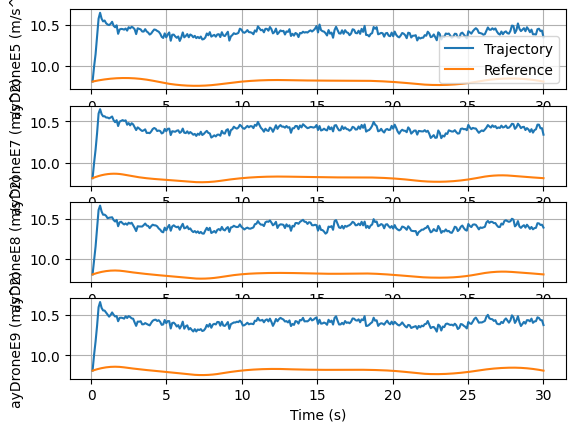

In [11]:
figT = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = figT.add_subplot(simulator['na'],1,i+1)
    ax1.plot(ts[1:],ur[0,:,i],label='Trajectory')
    ax1.plot(ts[1:],full_ref[i]["thrust"],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"ay{drone_bodies[i]} (m/s^2)")
    if (i==0):
        ax1.legend()
figT.savefig("./Simulation/ay_MPC_tracking.eps", format='eps')

for i in range(len(drone_bodies)):
    print((9.9 - max(full_ref[i]["thrust"]))/(4 * np.sqrt(3) * 8))



0.004539882330587723
0.004588933896812033
0.003124662947426265
0.00306468237340649


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


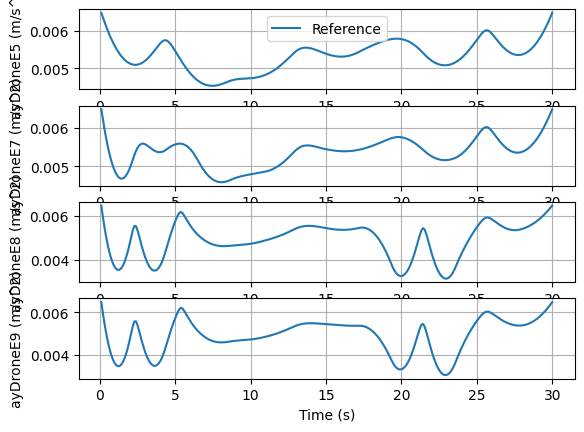

In [12]:
epsilon = 1.75 * np.pi / 180
cote = 1/np.tan(epsilon)

app = {}
for i in range(len(drone_bodies)):
    app[drone_bodies[i]] = (cote*np.sqrt( np.square(vref[uris[i]][:,0]) + 
                                         np.square(vref[uris[i]][:,1]) ) - vref[uris[i]][:,2] -g) / (-4 * a2 * (1+cote*np.sqrt(2)))
    
for i in range(len(drone_bodies)):
    print(min(app[drone_bodies[i]]))
    
figdc = plt.figure()
for i in range(len(drone_bodies)):  
    ax1 = figdc.add_subplot(simulator['na'],1,i+1)
    # ax1.plot(ts[1:],ur[0,:,i],label='Trajectory')
    ax1.plot(ts[1:],app[drone_bodies[i]],label='Reference')
    ax1.grid(True)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel(f"ay{drone_bodies[i]} (m/s^2)")
    if (i==0):
        ax1.legend()
figdc.savefig("./Simulation/ay_MPC_tracking.eps", format='eps')

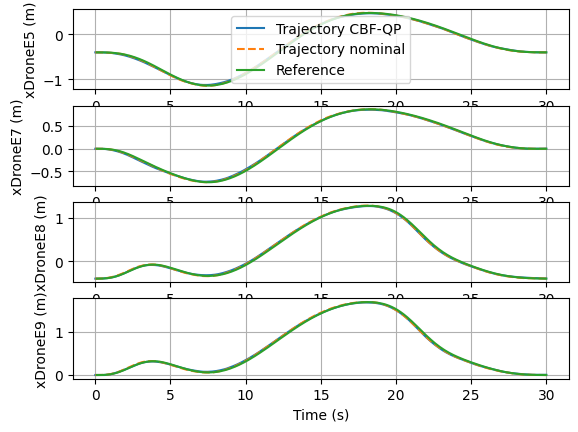

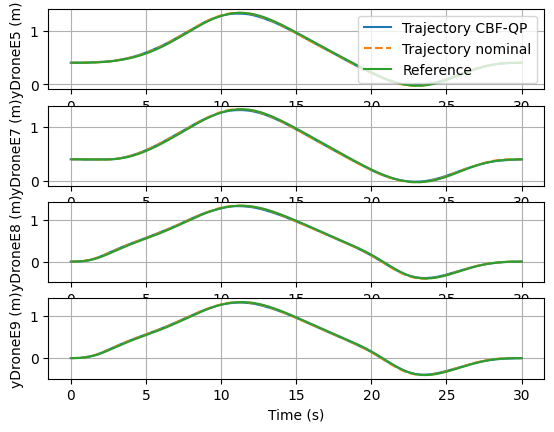

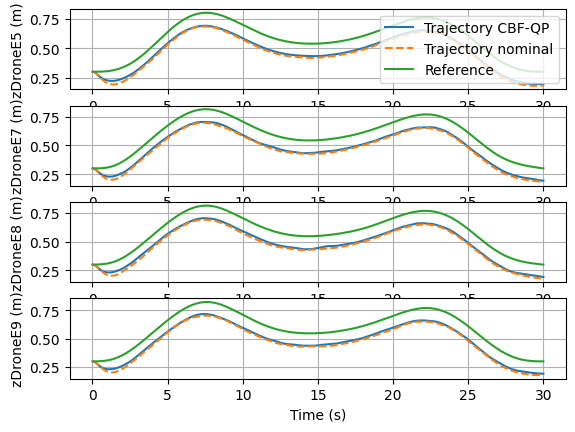

In [13]:
# plot position x
figxc = plt.figure()
for i in range(simulator['na']):
    axxc = figxc.add_subplot(simulator['na'],1,i+1)
    axxc.plot(ts,simulator['x_sim'][0,:,i],label='Trajectory CBF-QP')
    axxc.plot(ts,simulator['xn_sim'][0,:,i],label='Trajectory nominal',linestyle='dashed')
    axxc.plot(ts[1:],ref[uris[i]][:,0],label='Reference')
    axxc.grid(True)
    axxc.set_xlabel("Time (s)")
    axxc.set_ylabel(f"x{drone_bodies[i]} (m)")
    if (i==0):
        axxc.legend()

# plot position y
figyc = plt.figure()
for i in range(simulator['na']):
    axyc = figyc.add_subplot(simulator['na'],1,i+1)
    axyc.plot(ts,simulator['x_sim'][1,:,i],label='Trajectory CBF-QP')
    axyc.plot(ts,simulator['xn_sim'][1,:,i],label='Trajectory nominal',linestyle='dashed')
    axyc.plot(ts[1:],ref[uris[i]][:,1],label='Reference')
    axyc.grid(True)
    axyc.set_xlabel("Time (s)")
    axyc.set_ylabel(f"y{drone_bodies[i]} (m)")
    if (i==0):
        axyc.legend()

# plot position x
figzc = plt.figure()
for i in range(simulator['na']):
    axzc = figzc.add_subplot(simulator['na'],1,i+1)
    axzc.plot(ts,simulator['x_sim'][2,:,i],label='Trajectory CBF-QP')
    axzc.plot(ts,simulator['xn_sim'][2,:,i],label='Trajectory nominal',linestyle='dashed')
    axzc.plot(ts[1:],ref[uris[i]][:,2],label='Reference')
    axzc.grid(True)
    axzc.set_xlabel("Time (s)")
    axzc.set_ylabel(f"z{drone_bodies[i]} (m)")
    if (i==0):
        axzc.legend()


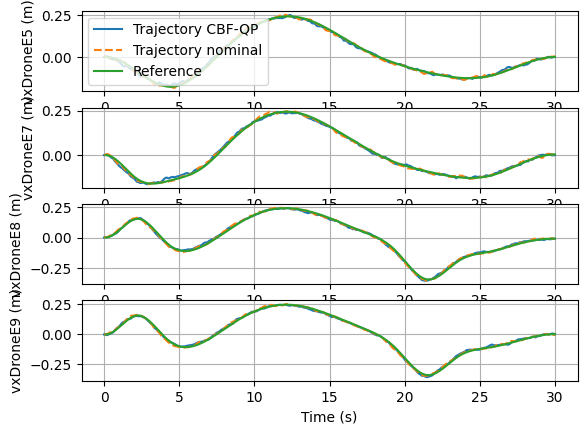

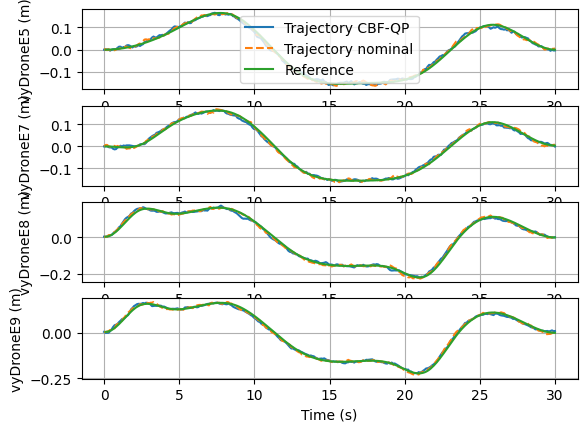

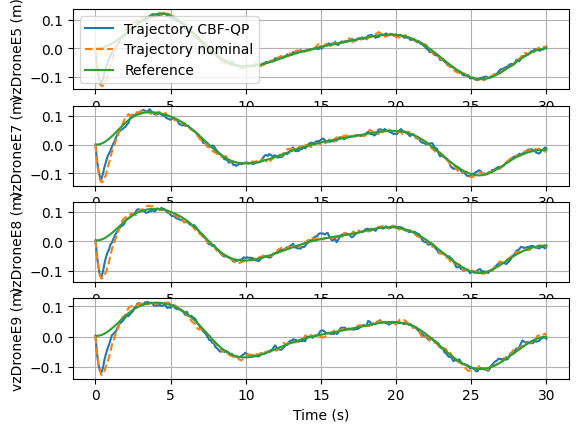

In [14]:
# plot position x
figvxc = plt.figure()
for i in range(simulator['na']):
    axvxc = figvxc.add_subplot(simulator['na'],1,i+1)
    axvxc.plot(ts,simulator['x_sim'][3,:,i],label='Trajectory CBF-QP')
    axvxc.plot(ts,simulator['xn_sim'][3,:,i],label='Trajectory nominal',linestyle='dashed')
    axvxc.plot(ts[1:],ref[uris[i]][:,3],label='Reference')
    axvxc.grid(True)
    axvxc.set_xlabel("Time (s)")
    axvxc.set_ylabel(f"vx{drone_bodies[i]} (m)")
    if (i==0):
        axvxc.legend()

# plot position y
figvyc = plt.figure()
for i in range(simulator['na']):
    axvyc = figvyc.add_subplot(simulator['na'],1,i+1)
    axvyc.plot(ts,simulator['x_sim'][4,:,i],label='Trajectory CBF-QP')
    axvyc.plot(ts,simulator['xn_sim'][4,:,i],label='Trajectory nominal',linestyle='dashed')
    axvyc.plot(ts[1:],ref[uris[i]][:,4],label='Reference')
    axvyc.grid(True)
    axvyc.set_xlabel("Time (s)")
    axvyc.set_ylabel(f"vy{drone_bodies[i]} (m)")
    if (i==0):
        axvyc.legend()

# plot position x
figvzc = plt.figure()
for i in range(simulator['na']):
    axvzc = figvzc.add_subplot(simulator['na'],1,i+1)
    axvzc.plot(ts,simulator['x_sim'][5,:,i],label='Trajectory CBF-QP')
    axvzc.plot(ts,simulator['xn_sim'][5,:,i],label='Trajectory nominal',linestyle='dashed')
    axvzc.plot(ts[1:],ref[uris[i]][:,5],label='Reference')
    axvzc.grid(True)
    axvzc.set_xlabel("Time (s)")
    axvzc.set_ylabel(f"vz{drone_bodies[i]} (m)")
    if (i==0):
        axvzc.legend()


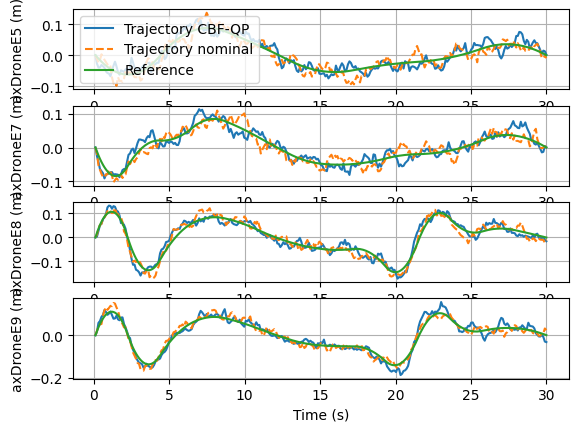

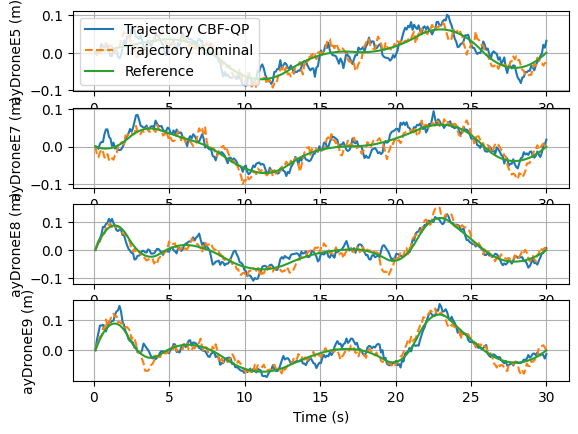

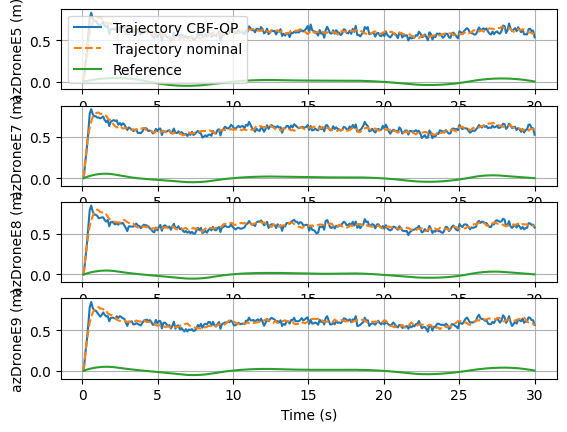

In [15]:
# plot acceleration ax
figaxc = plt.figure()
for i in range(simulator['na']):
    axaxc = figaxc.add_subplot(simulator['na'],1,i+1)
    axaxc.plot(ts[1:],simulator['u_sim'][0,:,i],label='Trajectory CBF-QP')
    axaxc.plot(ts[1:],simulator['un_sim'][0,:,i],label='Trajectory nominal',linestyle='dashed')
    axaxc.plot(ts[1:],vref[uris[i]][:,0],label='Reference')
    axaxc.grid(True)
    axaxc.set_xlabel("Time (s)")
    axaxc.set_ylabel(f"ax{drone_bodies[i]} (m)")
    if (i==0):
        axaxc.legend()

# plot acceleration ay
figayc = plt.figure()
for i in range(simulator['na']):
    axayc = figayc.add_subplot(simulator['na'],1,i+1)
    axayc.plot(ts[1:],simulator['u_sim'][1,:,i],label='Trajectory CBF-QP')
    axayc.plot(ts[1:],simulator['un_sim'][1,:,i],label='Trajectory nominal',linestyle='dashed')
    axayc.plot(ts[1:],vref[uris[i]][:,1],label='Reference')
    axayc.grid(True)
    axayc.set_xlabel("Time (s)")
    axayc.set_ylabel(f"ay{drone_bodies[i]} (m)")
    if (i==0):
        axayc.legend()

# plot acceleration az
figazc = plt.figure()
for i in range(simulator['na']):
    axazc = figazc.add_subplot(simulator['na'],1,i+1)
    axazc.plot(ts[1:],simulator['u_sim'][2,:,i],label='Trajectory CBF-QP')
    axazc.plot(ts[1:],simulator['un_sim'][2,:,i],label='Trajectory nominal',linestyle='dashed')
    axazc.plot(ts[1:],vref[uris[i]][:,2],label='Reference')
    axazc.grid(True)
    axazc.set_xlabel("Time (s)")
    axazc.set_ylabel(f"az{drone_bodies[i]} (m)")
    if (i==0):
        axazc.legend()

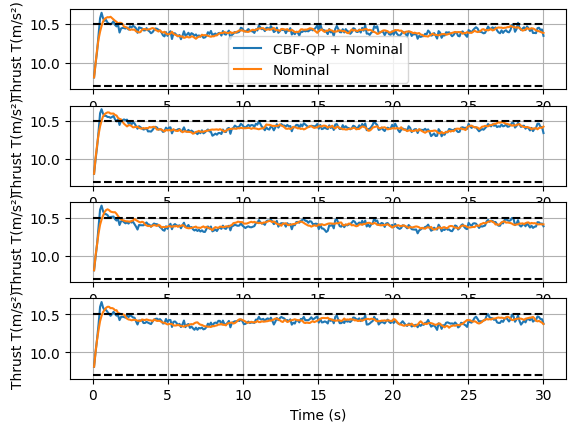

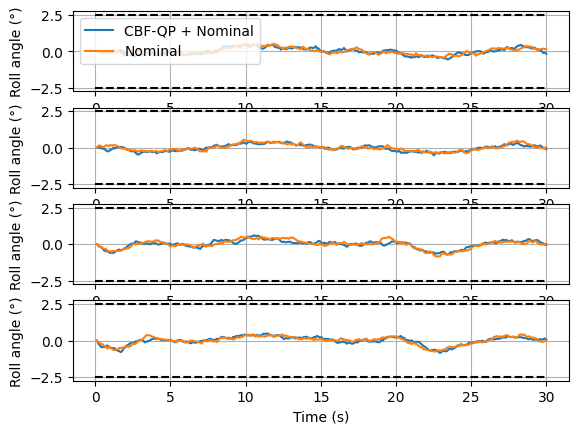

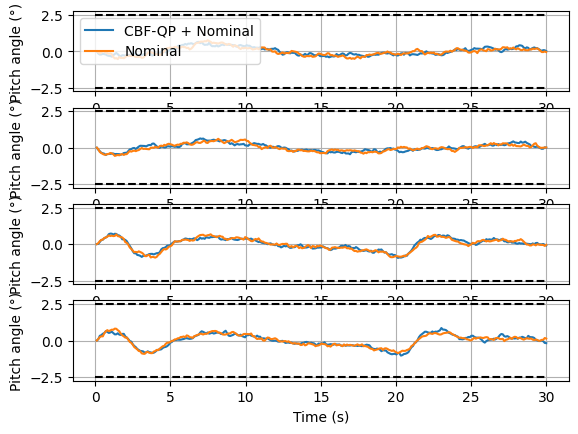

In [16]:
# Create a figure and axis object
figcc = plt.figure()

# plot Thrust
g = 9.81
Tmax = 10.5
for i in range(simulator['na']):
    axcc = figcc.add_subplot(simulator['na'],1,i+1)
    axcc.plot(ts[1:],ur[0,:,i],label='CBF-QP + Nominal')
    axcc.plot(ts[1:],urn[0,:,i],label='Nominal')
    axcc.grid(visible=True)

    axcc.plot(ts,np.ones(np.size(ts)) * Tmax,'k--',linewidth=1.5)
    axcc.plot(ts,np.ones(np.size(ts)) * 9.7,'k--',linewidth=1.5)
    axcc.set_xlabel('Time (s)')
    axcc.set_ylabel('Thrust T(m/s²)')
    if (i==0):
        axcc.legend()
# fig.savefig("./Simulation/Thrust_MPC_tracking.eps", format='eps')

phimax = 2.5 * np.pi/180
thetamax = 2.5 * np.pi/180

figrc = plt.figure()

for i in range(simulator['na']):
    axrc = figrc.add_subplot(simulator['na'],1,i+1)
    axrc.plot(ts[1:],ur[1,:,i]*180/np.pi,label='CBF-QP + Nominal')
    axrc.plot(ts[1:],urn[1,:,i]*180/np.pi,label='Nominal')
    axrc.grid(visible=True)

    axrc.plot(ts,np.ones(np.size(ts)) * phimax*180/np.pi,'k--',linewidth=1.5)
    axrc.plot(ts,np.ones(np.size(ts)) * -phimax*180/np.pi,'k--',linewidth=1.5)
    axrc.set_xlabel('Time (s)')
    axrc.set_ylabel('Roll angle (°)')
    if (i==0):
        axrc.legend()
# figrc.savefig("./Simulation/Roll_MPC_tracking.eps", format='eps')


figpc= plt.figure()

for i in range(simulator['na']):
    axpc = figpc.add_subplot(simulator['na'],1,i+1)
    axpc.plot(ts[1:],ur[2,:,i]*180/np.pi,label='CBF-QP + Nominal')
    axpc.plot(ts[1:],urn[2,:,i]*180/np.pi,label='Nominal')
    axpc.grid(visible=True)

    axpc.plot(ts,np.ones(np.size(ts)) * thetamax *180/np.pi,'k--',linewidth=1.5)
    axpc.plot(ts,np.ones(np.size(ts)) * -thetamax *180/np.pi,'k--',linewidth=1.5)
    axpc.set_xlabel('Time (s)')
    axpc.set_ylabel('Pitch angle (°)')
    if (i==0):
        axpc.legend()